In [1]:
import crocoddyl
import pinocchio
import numpy as np
import example_robot_data
#from crocoddyl.utils.biped import SimpleBipedGaitProblem
from biped_utils_rh5 import SimpleBipedGaitProblem
from pinocchio.robot_wrapper import RobotWrapper


crocoddyl.switchToNumpyMatrix()

# Creating the lower-body part of Talos
#talos_legs = example_robot_data.loadTalosLegs()

# Loading the RH5 Model
modelPath = "/home/dfki.uni-bremen.de/jesser/Dev/rh5-models"
URDF_FILENAME = "RH5Legs_PkgPath_PtContact.urdf"
URDF_SUBPATH = "/abstract-urdf/urdf/" + URDF_FILENAME

rh5_legs = RobotWrapper.BuildFromURDF(modelPath + URDF_SUBPATH, [modelPath], pinocchio.JointModelFreeFlyer()) # Load URDF file
#readParamsFromSrdf(robot, modelPath + SRDF_SUBPATH, False) # Load SRDF file
# Add the free-flyer joint limits (floating base)
rmodel = rh5_legs.model
ub = rmodel.upperPositionLimit
ub[:7] = 1
rmodel.upperPositionLimit = ub
lb = rmodel.lowerPositionLimit
lb[:7] = -1
rmodel.lowerPositionLimit = lb

# Setting up the 3d walking problem
rightFoot = 'FR_SupportCenter'
leftFoot = 'FL_SupportCenter'

#Debugging of defaultState 
#print(rh5_legs.model.nq) # 19 [7Root, 6 Left, 6 Right] -> Legs actually have 7 joints each, but AnkleFT is type=fixed!
#print(rh5_legs.model.nv)

In [2]:
gait = SimpleBipedGaitProblem(rh5_legs.model, rightFoot, leftFoot)

# Create the initial state
q0 = gait.q0
v0 = pinocchio.utils.zero(rh5_legs.model.nv)
x0 = np.concatenate([q0,v0])
#print(q0)

# Creating the walking problem
stepLength = 0.6 # meters
stepHeight = 0.1 # meters
timeStep = 0.0375 # seconds
stepKnots = 20
supportKnots = 10
problem = gait.createWalkingProblem(x0, stepLength, stepHeight, timeStep, stepKnots, supportKnots)

display = crocoddyl.GepettoDisplay(rh5_legs, 4, 4, frameNames=[rightFoot, leftFoot])
display.display(xs=[x0])

In [3]:
# Solving the 3d walking problem using Feasibility-prone DDP
ddp = crocoddyl.SolverFDDP(problem)
display = crocoddyl.GepettoDisplay(rh5_legs, 4, 4, frameNames=[rightFoot, leftFoot])
cameraTF = [3., 3.68, 0.84, 0.2, 0.62, 0.72, 0.22]
ddp.setCallbacks([crocoddyl.CallbackLogger(),
                  crocoddyl.CallbackVerbose(),
                  crocoddyl.CallbackDisplay(display)])
ddp.th_stop = 1e-9
init_xs = [rh5_legs.model.defaultState] * (problem.T + 1)
#print(rh5_legs.model.defaultState)
init_us = []
maxiter = 1000
regInit = 0.1
ddp.solve(init_xs, init_us, maxiter, False, regInit)

True

With the following commands we can plot 
 - the state and control trajectories, and
 - the DDP performance

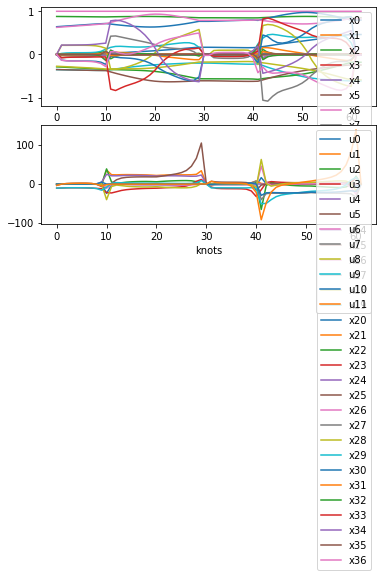

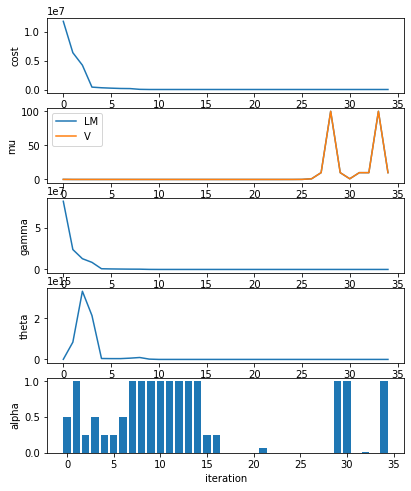

In [4]:
%matplotlib inline

# Plotting the solution and the DDP convergence
log = ddp.getCallbacks()[0]
crocoddyl.plotOCSolution(log.xs, log.us)
crocoddyl.plotConvergence(log.costs, log.u_regs, log.x_regs, log.grads, log.stops, log.steps)


Finally we can visualize the solution using gepetto-viewer.

In [5]:
# Visualization of the DDP solution in gepetto-viewer
#rate = 2.
#display.displayFromSolver(ddp, rate)

display = crocoddyl.GepettoDisplay(rh5_legs, frameNames=[rightFoot, leftFoot])
display.displayFromSolver(ddp)

## VI. Understanding the walking problem

In this problem we pre-defined a 20 and 10 knots for the step and double support phases with $dt=$3.75e-2, repectively. 

 1. Could you tell us how much is the foot step and double support duration?
 2. What happens when do we change $dt$ (e.g. 2e-2 secs)?
 3. What happens when do we change the number of step knots (e.g. 10)?
